In [1]:
HF_CHECKPOINT = "dccuchile/bert-base-spanish-wwm-cased"
PT_MODEL_NAME = "old-spanish-beto-cased"

AVAILABLE_GPU = 2

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= f"{AVAILABLE_GPU}" # ALWAYS look the one with 0% usage
tf_device=f'/gpu:{AVAILABLE_GPU}'

In [2]:
from datasets import load_dataset, Dataset
import pandas as pd
import re
from transformers import AutoModel, AutoTokenizer
import torch
from torch.nn.functional import normalize
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_distances
import numpy as np
import matplotlib.pyplot as plt
import json
import warnings
from sklearn.manifold import TSNE
import seaborn as sns
#warnings.filterwarnings('ignore')

/home/historynlp/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def printred(text, word):
    index = 0
    while index < len(text):
        if text[index:index+len(word)] == word:
            print('\033[91m' + text[index:index+len(word)] + '\033[0m', end='')
            index += len(word)
        else:
            print(text[index], end='')
            index += 1

def find_sub_list(sl,l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll

printred("There was a lot of persons.", "person")

There was a lot of persons.

In [4]:
old_dataset = Dataset.from_pandas(
    pd.read_csv("./data/old-spanish-corpus-chunked.tsv", sep="\t", usecols=["text", "source", "source_id", "source_text_id", "date"], dtype={'source_id':str,'source_text_id':str,'date':str})
)
old_dataset = old_dataset.shuffle(seed=42)

old_dataset_latam = old_dataset.filter(lambda example: example["source"] == "19th century Latam Newspapers")
print("OLD dataset:", old_dataset_latam if "latam" in PT_MODEL_NAME else old_dataset)

Filter: 100%|██████████████| 1718997/1718997 [00:10<00:00, 165178.90 examples/s]

OLD dataset: Dataset({
    features: ['source', 'source_id', 'source_text_id', 'date', 'text'],
    num_rows: 1718997
})


In [5]:
modern_dataset = load_dataset("large_spanish_corpus", "EUBookShop", trust_remote_code=True)["train"]
modern_dataset = modern_dataset.shuffle(seed=42)
print("MODERN dataset:", modern_dataset)

MODERN dataset: Dataset({
    features: ['text'],
    num_rows: 8214959
})


In [6]:
tokenizer = AutoTokenizer.from_pretrained(HF_CHECKPOINT)

model_old = torch.load(f"./output/{PT_MODEL_NAME}.pt")
model_new = AutoModel.from_pretrained(HF_CHECKPOINT)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_old = model_old.to(device)
model_new = model_new.to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
with open("./data/surfaceFormsNonAccents.json") as f:
    surfaceForms = json.load(f)

with open("./data/target-words.txt") as f:
    targets = [w.strip() for w in f.readlines()]

In [8]:
MAX_N_OLD = 500
LOWEST_EXPECTED_OLD = 100
FACTOR_IF_LOWER = 3

searchs = []
for t in targets:
    search = [t]
    search.extend(surfaceForms.get(t, []))
    searchs.append(search)

searchs

[['gente', 'jente'],
 ['servidores'],
 ['humanitaria'],
 ['humor'],
 ['privilegiado', 'privilejiado'],
 ['ventajosa'],
 ['hombre'],
 ['placer'],
 ['razón'],
 ['juicio'],
 ['excitación', 'escitación'],
 ['urbanidad'],
 ['academia'],
 ['miserable'],
 ['nebulosas'],
 ['privado'],
 ['diablo'],
 ['luces', 'luzes'],
 ['genio', 'jenio'],
 ['mujeres', 'mugeres']]

In [9]:
data = {"word":[], "orth":[], "period":[], "sense_old":[], "sense_new":[], "source":[], "text":[], "embedding_new":[], "embedding_old":[]}

for search in searchs:
    w = search[0]
    print(f"Searching: {w} as {search}")

    i = 0
    for example in (old_dataset_latam if "latam" in PT_MODEL_NAME else old_dataset):
        text = example["text"]
        for s in search:
            match = re.search(r'\b' + re.escape(s) + r'\b', text)
            if match:
                # Word found!
                inp = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding='max_length')
                try: idx, idxF = find_sub_list(tokenizer(s)['input_ids'][1:-1], inp['input_ids'].tolist()[0])
                except TypeError: continue
                assert tokenizer.decode(inp['input_ids'][0][idx:idxF]) == s, f"Expected {s} but got {tokenizer.decode(inp['input_ids'][0][idx:idxF])}"
                with torch.no_grad():
                    input_ids = inp["input_ids"].to(device)
                    attention_mask = inp["attention_mask"].to(device)
                    embedding_new_old = model_new(input_ids, attention_mask=attention_mask, output_hidden_states=True).last_hidden_state[0][idx].cpu()
                    embedding_old_old = model_old(input_ids, attention_mask=attention_mask, output_hidden_states=True).hidden_states[-1][0][idx].cpu()

                data['word'].append(w)
                data['orth'].append(s)
                data['period'].append('old')
                data['sense_old'].append(None)
                data['sense_new'].append(None)
                data['source'].append(f"{example['source']}-{example['source_id']}-{example['source_text_id']}")
                data['text'].append(text)
                data['embedding_new'].append(normalize(embedding_new_old, p=2, dim=-1))
                data['embedding_old'].append(normalize(embedding_old_old, p=2, dim=-1))

                i += 1
                break
        if i == MAX_N_OLD:
            break
    print(f"{w}: found {i} in OLD ", end="")

    j,n = 0,0
    MAX_N_NEW = min(MAX_N_OLD, FACTOR_IF_LOWER*i if i < LOWEST_EXPECTED_OLD else i)
    for example in modern_dataset:
        text = example["text"]
        match = re.search(r'\b' + re.escape(w) + r'\b', text)
        if match:
            # Word found!
            inp = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding='max_length')
            try: idx, idxF = find_sub_list(tokenizer(w)['input_ids'][1:-1], inp['input_ids'].tolist()[0])
            except TypeError: continue
            assert tokenizer.decode(inp['input_ids'][0][idx:idxF]) == w, f"Expected {w} but got {tokenizer.decode(inp['input_ids'][0][idx:idxF])}"
            with torch.no_grad():
                input_ids = inp["input_ids"].to(device)
                attention_mask = inp["attention_mask"].to(device)
                embedding_new_new = model_new(input_ids, attention_mask=attention_mask, output_hidden_states=True).last_hidden_state[0][idx].cpu()
                embedding_old_new = model_old(input_ids, attention_mask=attention_mask, output_hidden_states=True).hidden_states[-1][0][idx].cpu()
            
            data['word'].append(w)
            data['orth'].append(w)
            data['period'].append('new')
            data['sense_old'].append(None)
            data['sense_new'].append(None)
            data['source'].append(f"large_spanish_corpus-EUBookShop-{n}")
            data['text'].append(text)
            data['embedding_new'].append(normalize(embedding_new_new, p=2, dim=-1))
            data['embedding_old'].append(normalize(embedding_old_new, p=2, dim=-1))
            
            j += 1
        if j == MAX_N_NEW:
            break
        n += 1
    print(f"and {j} in NEW")

df = pd.DataFrame(data)
df

Searching: gente as ['gente', 'jente']
gente: found 500 in OLD and 500 in NEW
Searching: servidores as ['servidores']
servidores: found 500 in OLD and 260 in NEW
Searching: humanitaria as ['humanitaria']
humanitaria: found 225 in OLD and 225 in NEW
Searching: humor as ['humor']
humor: found 500 in OLD and 236 in NEW
Searching: privilegiado as ['privilegiado', 'privilejiado']
privilegiado: found 500 in OLD and 500 in NEW
Searching: ventajosa as ['ventajosa']
ventajosa: found 500 in OLD and 500 in NEW
Searching: hombre as ['hombre']
hombre: found 500 in OLD and 500 in NEW
Searching: placer as ['placer']
placer: found 500 in OLD and 500 in NEW
Searching: razón as ['razón']
razón: found 500 in OLD and 500 in NEW
Searching: juicio as ['juicio']
juicio: found 500 in OLD and 500 in NEW
Searching: excitación as ['excitación', 'escitación']
excitación: found 500 in OLD and 39 in NEW
Searching: urbanidad as ['urbanidad']
urbanidad: found 500 in OLD and 10 in NEW
Searching: academia as ['academia

word     orth period sense_old sense_new  \
0        gente    gente    old      None      None   
1        gente    gente    old      None      None   
2        gente    gente    old      None      None   
3        gente    gente    old      None      None   
4        gente    gente    old      None      None   
...        ...      ...    ...       ...       ...   
15607  mujeres  mujeres    new      None      None   
15608  mujeres  mujeres    new      None      None   
15609  mujeres  mujeres    new      None      None   
15610  mujeres  mujeres    new      None      None   
15611  mujeres  mujeres    new      None      None   

                                      source  \
0             The British Library-3436138-12   
1             The British Library-3436138-15   
2             The British Library-3436138-25   
3             The British Library-3436138-31   
4             The British Library-3436138-32   
...                                      ...   
15607  large_spanish_corpus-EUBookShop-65863   
15608  large_spanish_corpus-EUBookShop-65870   
15609  large_spanish_corpus-EUBookShop-65876   
15610  large_spanish_corpus-EUBookShop-65893   
15611  large_spanish_corpus-EUBookShop-65894   

                                                    text  \
0      CONQUISTA quartel observando la batalla, y rec...   
1      DE NUEVA ESPAÑA. 5 " garlos por complacerle, l...   
2      Duraron toda la noche los alaridos y clamores ...   
3      DE NUEVA ESPAÑA. 21 CAPITULO XVI. Vuelven los ...   
4      CONQUISTA 22 paz, no volvieron con respuesta ;...   
...                                                  ...   
15607  Manual sobre igualdad de trato entre hombres y...   
15608  4) ¿Puede la política aplicada por un jefe de ...   
15609  En virtud del artículo 6 de dicha Directiva, i...   
15610  A este res pecto, no podía excluirse la posibi...   
15611  En sus cuestiones cuarta y quinta, el Industri...   

                                           embedding_new  \
0      [tensor(0.0202), tensor(-0.0448), tensor(0.011...   
1      [tensor(0.0338), tensor(-0.0663), tensor(-0.00...   
2      [tensor(0.0080), tensor(-0.0717), tensor(-0.00...   
3      [tensor(0.0141), tensor(-0.0544), tensor(-0.00...   
4      [tensor(0.0257), tensor(-0.0469), tensor(-0.02...   
...                                                  ...   
15607  [tensor(-0.0197), tensor(0.0330), tensor(-0.06...   
15608  [tensor(0.0106), tensor(-0.0215), tensor(-0.05...   
15609  [tensor(-0.0064), tensor(0.0182), tensor(-0.04...   
15610  [tensor(0.0023), tensor(-0.0220), tensor(-0.03...   
15611  [tensor(-0.0217), tensor(-0.0284), tensor(-0.0...   

                                           embedding_old  
0      [tensor(0.0024), tensor(-0.0341), tensor(0.001...  
1      [tensor(0.0238), tensor(-0.0707), tensor(0.012...  
2      [tensor(0.0338), tensor(-0.0852), tensor(-0.00...  
3      [tensor(0.0421), tensor(-0.0417), tensor(0.002...  
4      [tensor(0.0182), tensor(-0.0389), tensor(-0.00...  
...                                                  ...  
15607  [tensor(0.0040), tensor(0.0493), tensor(-0.036...  
15608  [tensor(0.0175), tensor(-0.0355), tensor(-0.05...  
15609  [tensor(0.0181), tensor(0.0331), tensor(-0.019...  
15610  [tensor(0.0359), tensor(0.0047), tensor(-0.034...  
15611  [tensor(-0.0010), tensor(-0.0373), tensor(-0.0...  

[15612 rows x 9 columns]

In [10]:
SHOULD_PRINT = True

def get_silhouette(tensors, kmeans):
    n = kmeans.n_clusters
    labels = kmeans.labels_
    if n == 1: return 0 # doesn't allow 1-cluster solutions
    X = np.array([tensor.flatten().numpy() for tensor in tensors])
    return silhouette_score(X, labels=labels, metric='euclidean')

def elbow_method(inertia_values):
    deltas = []
    for i in range(1, len(inertia_values)):
        deltas.append(inertia_values[i - 1] - inertia_values[i])
    max_curvature_index = deltas.index(max(deltas))
    return max_curvature_index + 2

def compute_metric(tensors, kmeans, method="silhouette"):
    return get_silhouette(tensors, kmeans) if method == "silhouette" else 0

def KMeans_df(df, metric):
    best_score_new, best_n_new, inertias_new = -1, 0, []
    best_score_old, best_n_old, inertias_old = -1, 0, []
    
    min_clusters = 1
    max_clusters = int(len(df)**.5)+1

    for n in range(min_clusters, max_clusters):
        kmeans_new = KMeans(n_clusters=n, random_state=0, n_init='auto')
        kmeans_new.fit([t.numpy() for t in df['embedding_new'].tolist()])
        df[f'sense_new_{n}'] = kmeans_new.labels_
        if (metric == 'inertia'):
            inertias_new.append(kmeans_new.inertia_)
        else:
            score_new = compute_metric(df['embedding_new'], kmeans_new, metric)
            if (metric == 'silhouette') and (score_new > best_score_new):
                best_score_new, best_n_new = score_new, n
            elif (metric == 'compactness') and (score_new > best_score_new):
                best_score_new, best_n_new = score_new, n

        kmeans_old = KMeans(n_clusters=n, random_state=0, n_init='auto')
        kmeans_old.fit([t.numpy() for t in df['embedding_old'].tolist()])
        df[f'sense_old_{n}'] = kmeans_old.labels_
        if (metric == 'inertia'):
            inertias_old.append(kmeans_old.inertia_)
        else:
            score_old = compute_metric(df['embedding_old'], kmeans_old, metric)
            if (metric == 'silhouette') and (score_old > best_score_old):
                best_score_old, best_n_old = score_old, n
            elif (metric == 'compactness') and (score_old > best_score_old):
                best_score_old, best_n_old = score_old, n
    
    if metric == 'inertia':
        best_n_new = elbow_method(inertias_new)
        best_n_old = elbow_method(inertias_old)
        if SHOULD_PRINT:
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.plot(range(min_clusters, len(inertias_new) + 1), inertias_new, marker='o')
            plt.xlabel('Number of clusters')
            plt.ylabel('Inertia')
            plt.title('Inertia (new model)')

            plt.subplot(1, 2, 2)
            plt.plot(range(min_clusters, len(inertias_old) + 1), inertias_old, marker='o')
            plt.xlabel('Number of clusters')
            plt.ylabel('Inertia')
            plt.title('Inertia (old model)')

            plt.suptitle(f"Inertia for word '{df.iloc[0]['word']}'")
            plt.show()

    df['sense_new'] = df[f'sense_new_{best_n_new}']
    df = df.drop(columns=[f'sense_new_{n}' for n in range(min_clusters, max_clusters)])
    df['sense_old'] = df[f'sense_old_{best_n_old}']
    df = df.drop(columns=[f'sense_old_{n}' for n in range(min_clusters, max_clusters)])

    if SHOULD_PRINT:
        print(f"\n{df.iloc[0]['word']}")
        print("Best number of clusters (new):", best_n_new, f"[max {max_clusters}]")
        print("Best number of clusters (old):", best_n_old, f"[max {max_clusters}]")

    return df

def AffinityP_df(df, damping=0.5):
    cd_new = cosine_distances([t.numpy() for t in df['embedding_new'].tolist()])
    cd_old = cosine_distances([t.numpy() for t in df['embedding_old'].tolist()])
    
    ap_new = AffinityPropagation(affinity='precomputed', damping=damping)
    ap_new.fit(cd_new)
    ap_old = AffinityPropagation(affinity='precomputed', damping=damping)
    ap_old.fit(cd_old)
    
    df['sense_new'] = ap_new.labels_
    df['sense_old'] = ap_old.labels_

    if SHOULD_PRINT:
        print(f"\n{df.iloc[0]['word']}")
        print("Best number of clusters (new):", len(ap_new.cluster_centers_indices_))
        print("Best number of clusters (old):", len(ap_old.cluster_centers_indices_))
    
    return df

def clustering(df, method, metric):
    return KMeans_df(df, metric) if method == "KM" else AffinityP_df(df, metric)

def cluster_df(df, method="AP", metric="silhouette"):
    result_df = pd.DataFrame()
    for word, group in df.groupby('word'):
        group_cl = clustering(group, method, metric)
        result_df = pd.concat([result_df, group_cl], ignore_index=True)
        assert len(group) == len(group_cl), f"{len(group)} != {len(group_cl)} for word {word}"

    return result_df.reset_index()

In [37]:
CLUSTERING_METHOD = "AP" # "KMeans" or "AP"
CLUSTERING_METRIC = 0.975 # For KMeans: "silhouette" or "inertia". For AP: the damping value (between 0.5, 0.99)

result_df = cluster_df(df, CLUSTERING_METHOD, CLUSTERING_METRIC)


academia
Best number of clusters (new): 1
Best number of clusters (old): 3

diablo
Best number of clusters (new): 2
Best number of clusters (old): 3

excitación
Best number of clusters (new): 2
Best number of clusters (old): 1

genio
Best number of clusters (new): 1
Best number of clusters (old): 2

gente
Best number of clusters (new): 1
Best number of clusters (old): 1

hombre
Best number of clusters (new): 2
Best number of clusters (old): 8

humanitaria
Best number of clusters (new): 1
Best number of clusters (old): 4

humor
Best number of clusters (new): 3
Best number of clusters (old): 5

juicio
Best number of clusters (new): 2
Best number of clusters (old): 1

luces
Best number of clusters (new): 2
Best number of clusters (old): 4

miserable
Best number of clusters (new): 2
Best number of clusters (old): 5

mujeres
Best number of clusters (new): 2
Best number of clusters (old): 2

nebulosas
Best number of clusters (new): 1
Best number of clusters (old): 3

placer
Best number of c

In [38]:
result_df

index       word       orth period  sense_old  sense_new  \
0          0   academia   academia    old          2          0   
1          1   academia   academia    old          2          0   
2          2   academia   academia    old          1          0   
3          3   academia   academia    old          2          0   
4          4   academia   academia    old          1          0   
...      ...        ...        ...    ...        ...        ...   
15607  15607  ventajosa  ventajosa    new          0          1   
15608  15608  ventajosa  ventajosa    new          0          1   
15609  15609  ventajosa  ventajosa    new          0          1   
15610  15610  ventajosa  ventajosa    new          0          1   
15611  15611  ventajosa  ventajosa    new          2          1   

                                        source  \
0              The British Library-2476293-493   
1              The British Library-2476293-621   
2                 The British Library-427781-9   
3               The British Library-427781-207   
4               The British Library-427781-220   
...                                        ...   
15607  large_spanish_corpus-EUBookShop-6519238   
15608  large_spanish_corpus-EUBookShop-6551922   
15609  large_spanish_corpus-EUBookShop-6551929   
15610  large_spanish_corpus-EUBookShop-6551958   
15611  large_spanish_corpus-EUBookShop-6551963   

                                                    text  \
0      El misino sr. Escudero dijo, que á virtud de l...   
1      615 teria deben ser muy recomendables por los ...   
2      acércate.... contémplanos, llora sobre estos e...   
3      193 Los tribunales de las provincias debían da...   
4      Hablar de esto es para muchos contar fábulas M...   
...                                                  ...   
15607  La atribución de los pedidos de números suelto...   
15608  Prejudicial «Directiva 93I36ICEE — Contratos p...   
15609  «Oferta económicamente más ventajosa según los...   
15610  En primer lugar, tiene por objeto averiguar si...   
15611  Cuando la entidad adjudicadora decide adjudica...   

                                           embedding_new  \
0      [tensor(-0.0260), tensor(-0.0497), tensor(0.00...   
1      [tensor(-0.0004), tensor(-0.0222), tensor(-0.0...   
2      [tensor(-0.0097), tensor(-0.0253), tensor(-0.0...   
3      [tensor(0.0209), tensor(-0.0393), tensor(-0.00...   
4      [tensor(-0.0219), tensor(-0.0354), tensor(-0.0...   
...                                                  ...   
15607  [tensor(0.0283), tensor(-0.0344), tensor(0.014...   
15608  [tensor(0.0219), tensor(-0.0450), tensor(0.008...   
15609  [tensor(6.0064e-05), tensor(-0.0316), tensor(0...   
15610  [tensor(0.0173), tensor(-0.0422), tensor(0.002...   
15611  [tensor(0.0155), tensor(-0.0492), tensor(0.019...   

                                           embedding_old  
0      [tensor(-0.0398), tensor(-0.0619), tensor(0.01...  
1      [tensor(-0.0217), tensor(-0.0499), tensor(-0.0...  
2      [tensor(-0.0419), tensor(-0.0389), tensor(0.00...  
3      [tensor(-0.0085), tensor(-0.0469), tensor(-0.0...  
4      [tensor(-0.0431), tensor(-0.0250), tensor(-0.0...  
...                                                  ...  
15607  [tensor(0.0482), tensor(0.0037), tensor(-0.039...  
15608  [tensor(-0.0029), tensor(-0.0319), tensor(-0.0...  
15609  [tensor(-0.0050), tensor(-0.0143), tensor(0.00...  
15610  [tensor(0.0408), tensor(-0.0177), tensor(0.006...  
15611  [tensor(0.0173), tensor(-0.0161), tensor(-0.00...  

[15612 rows x 10 columns]

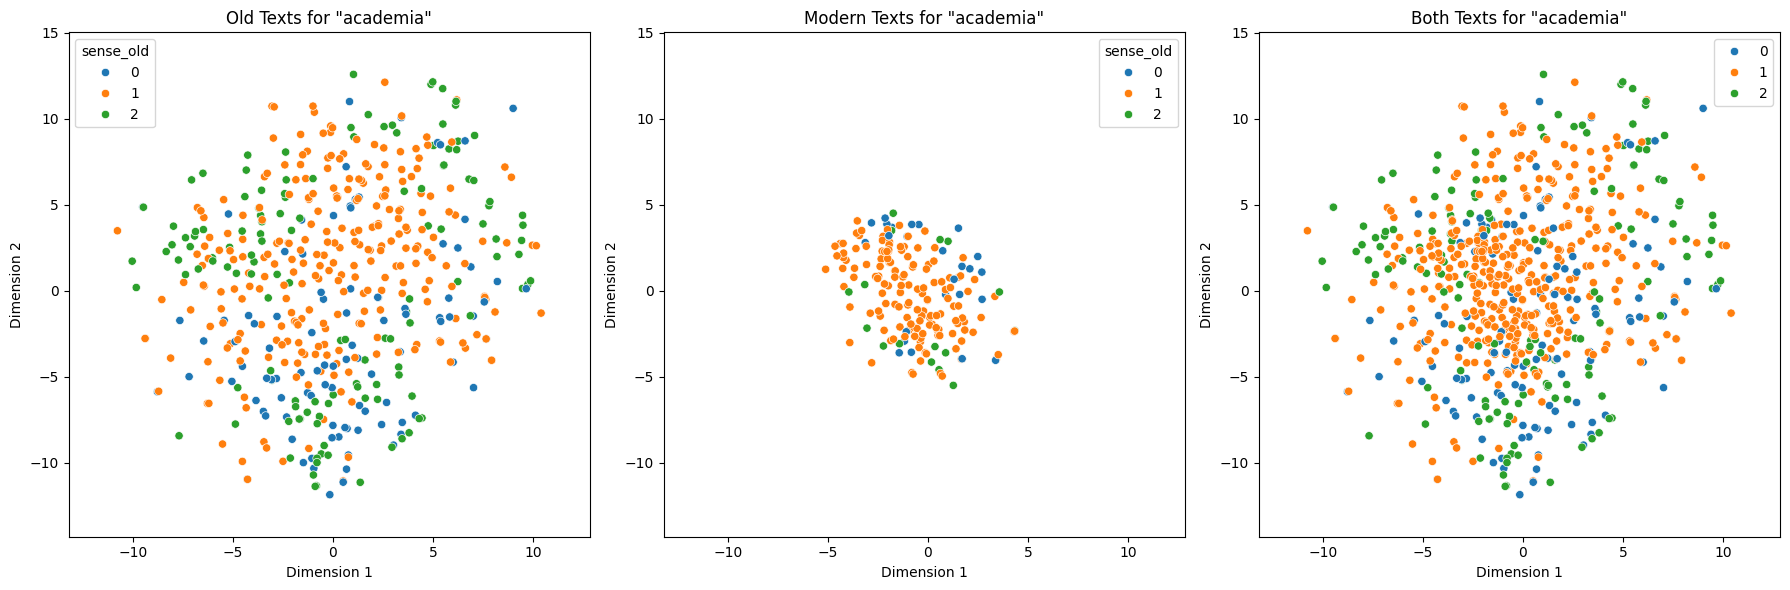

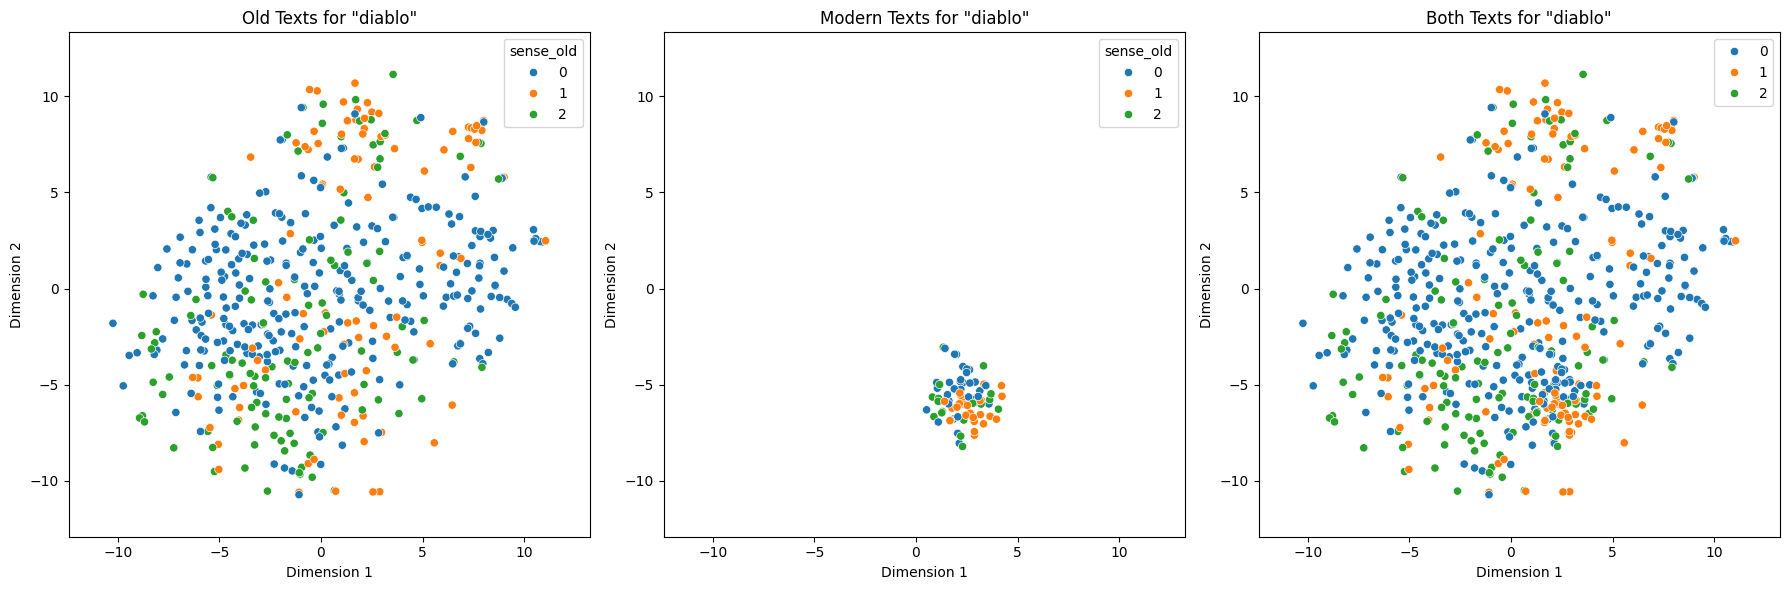

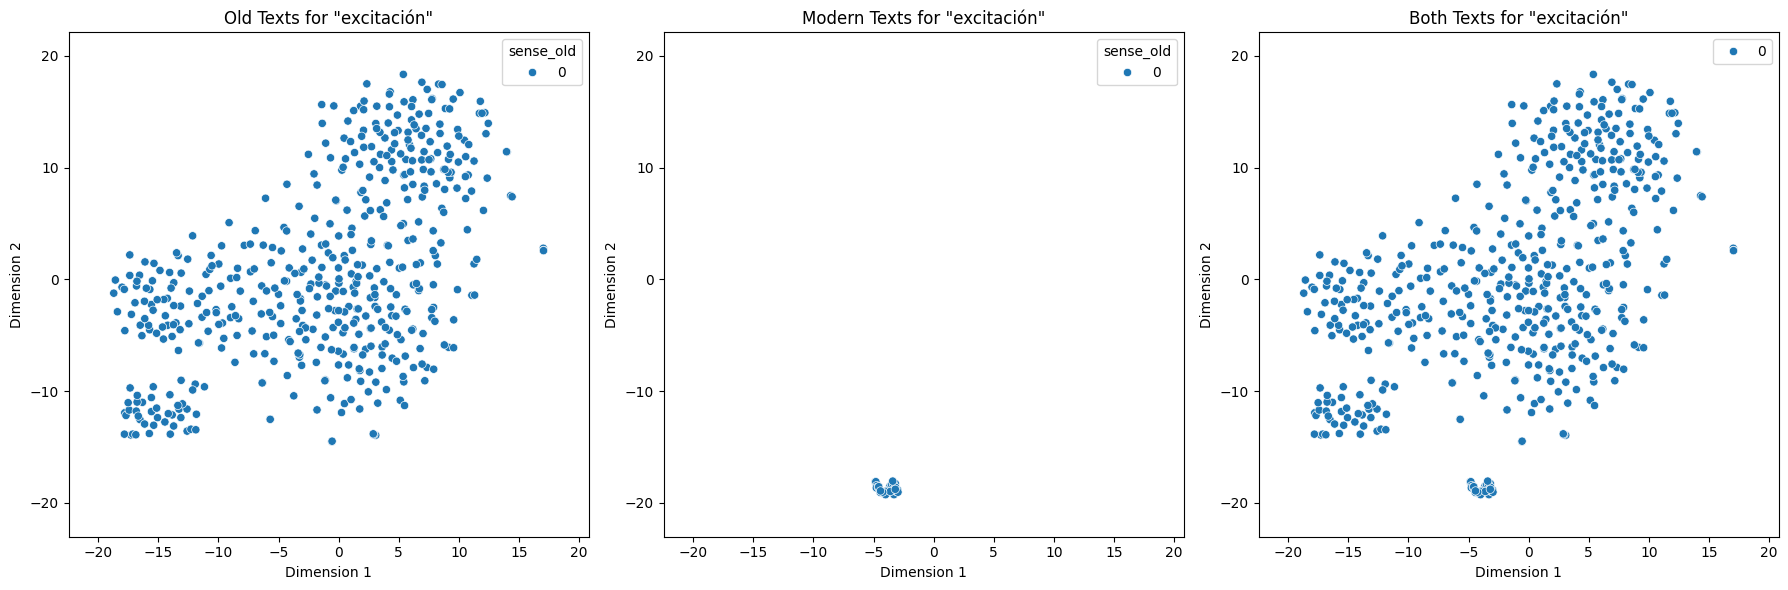

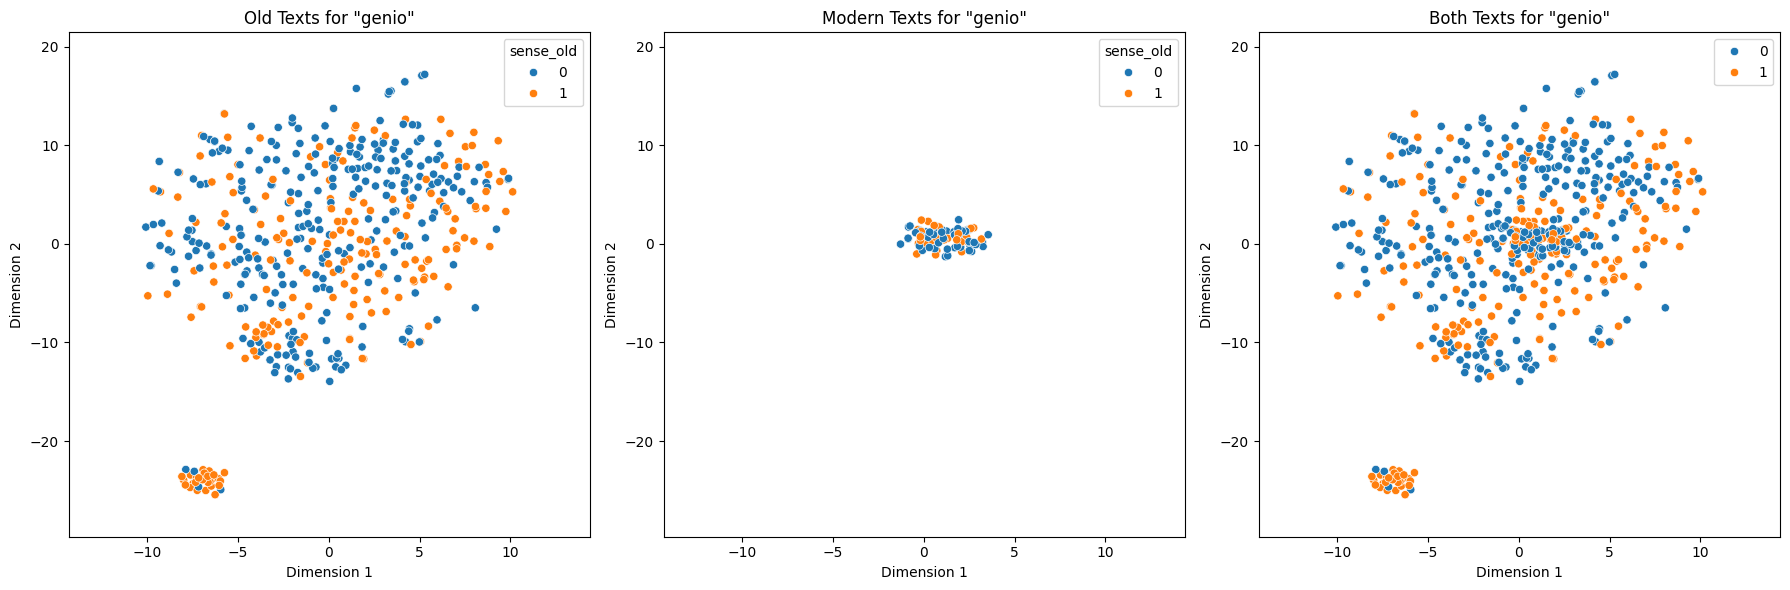

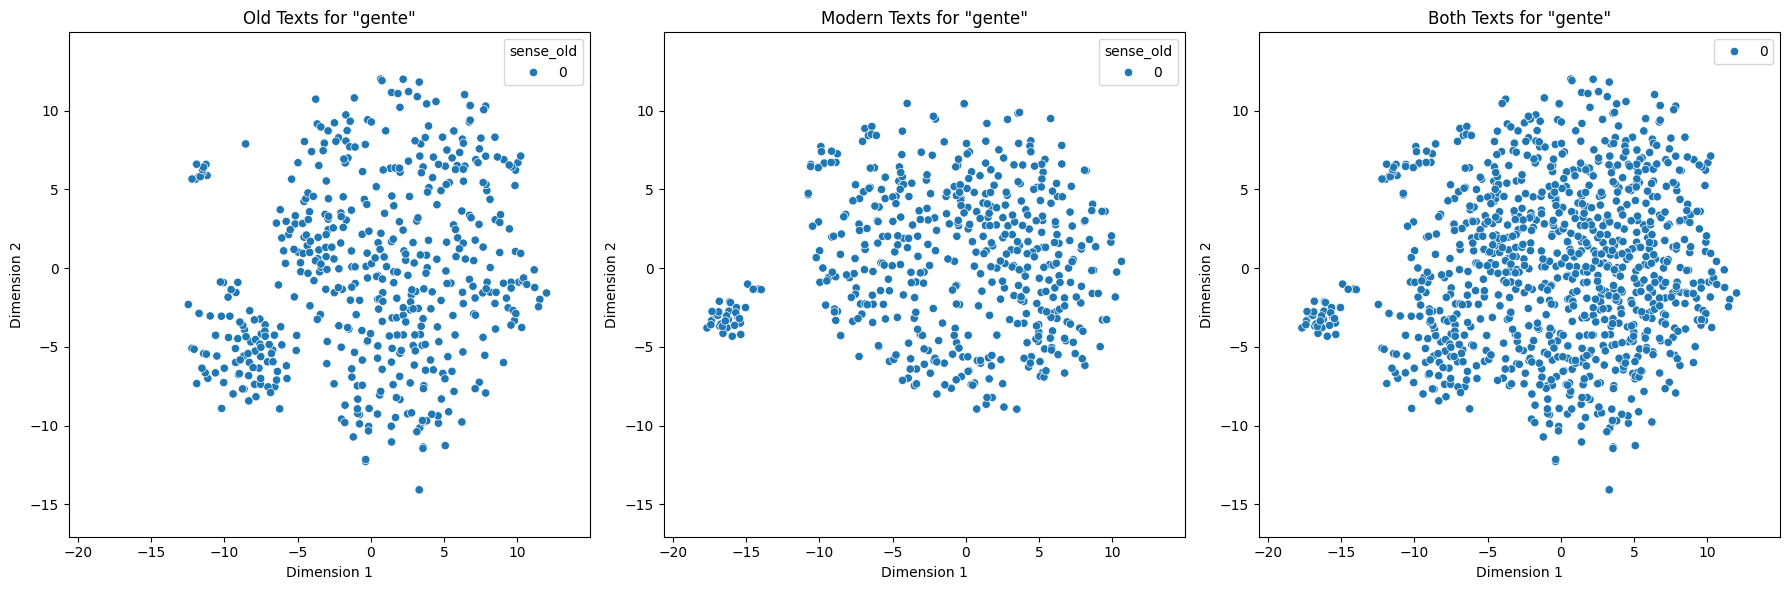

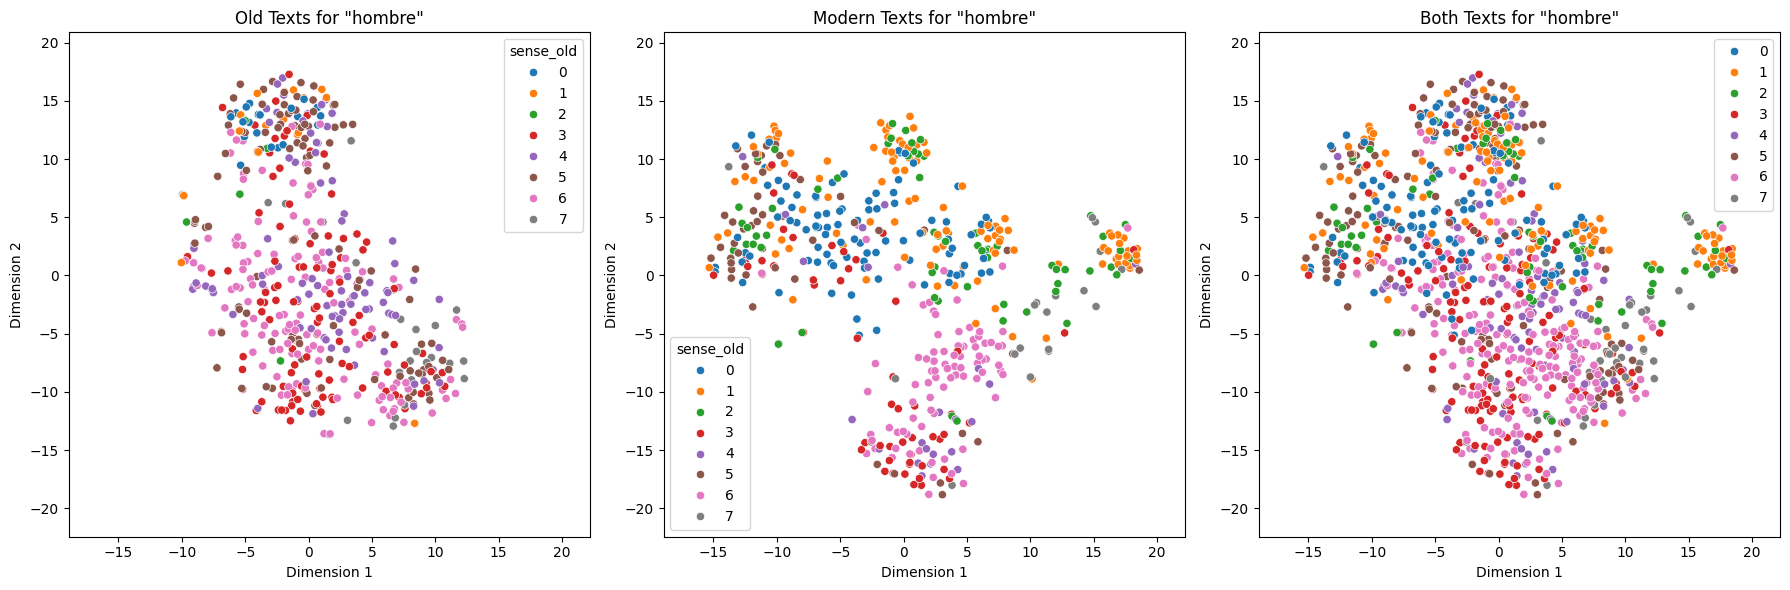

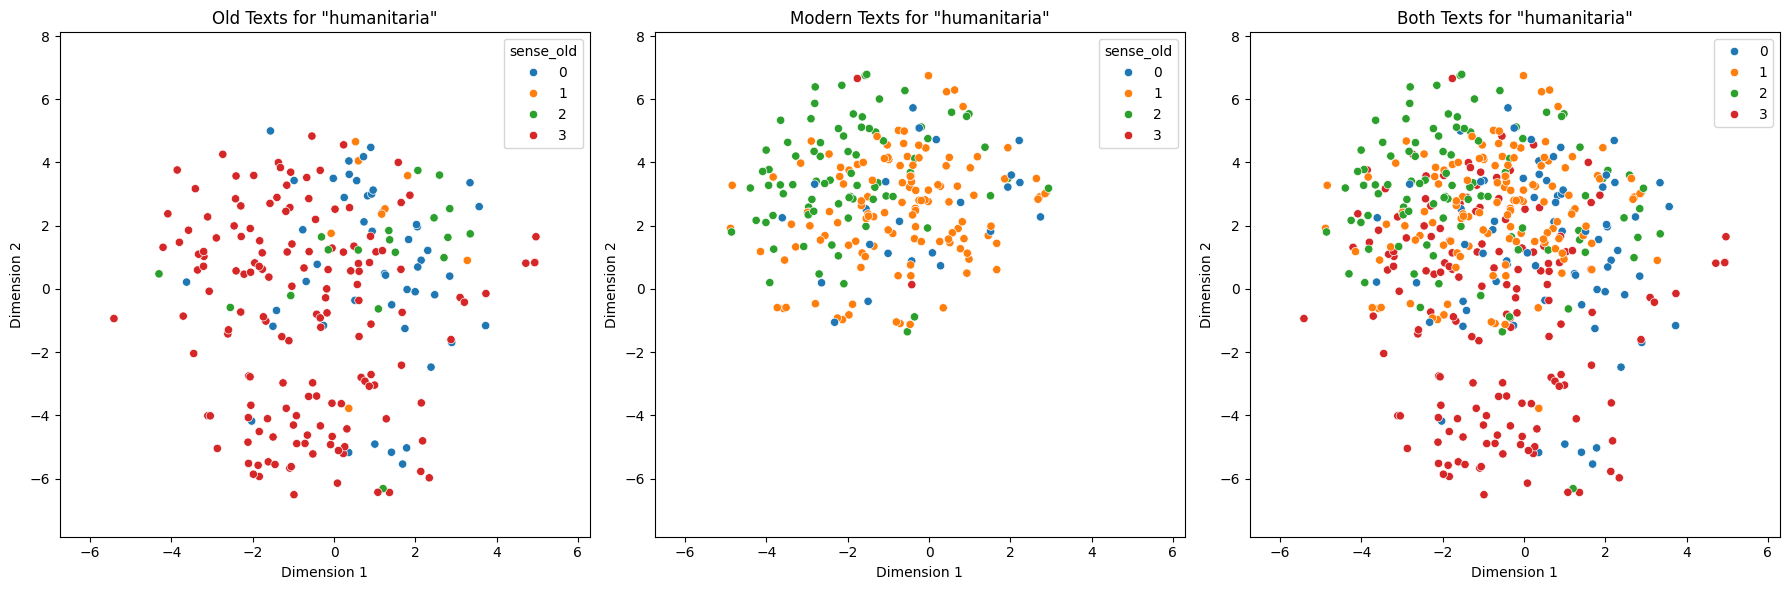

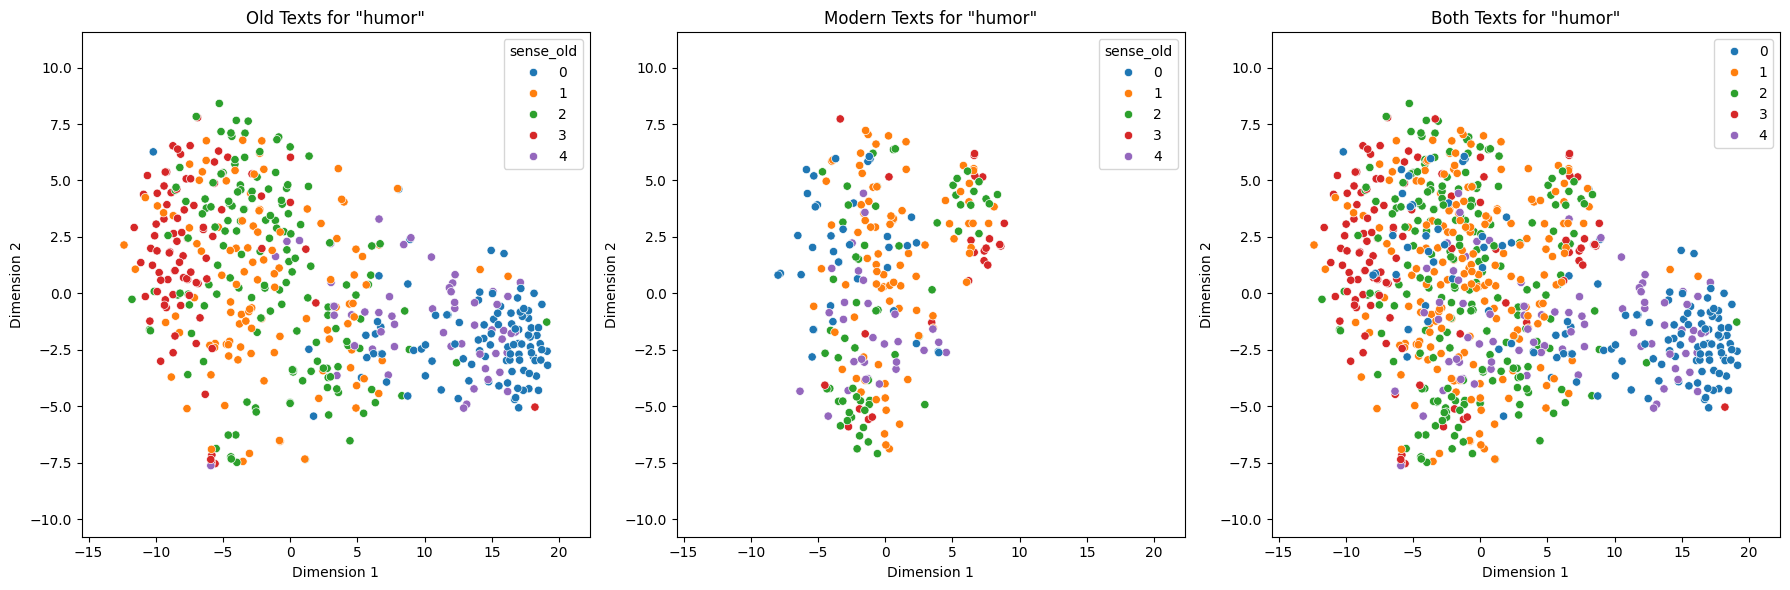

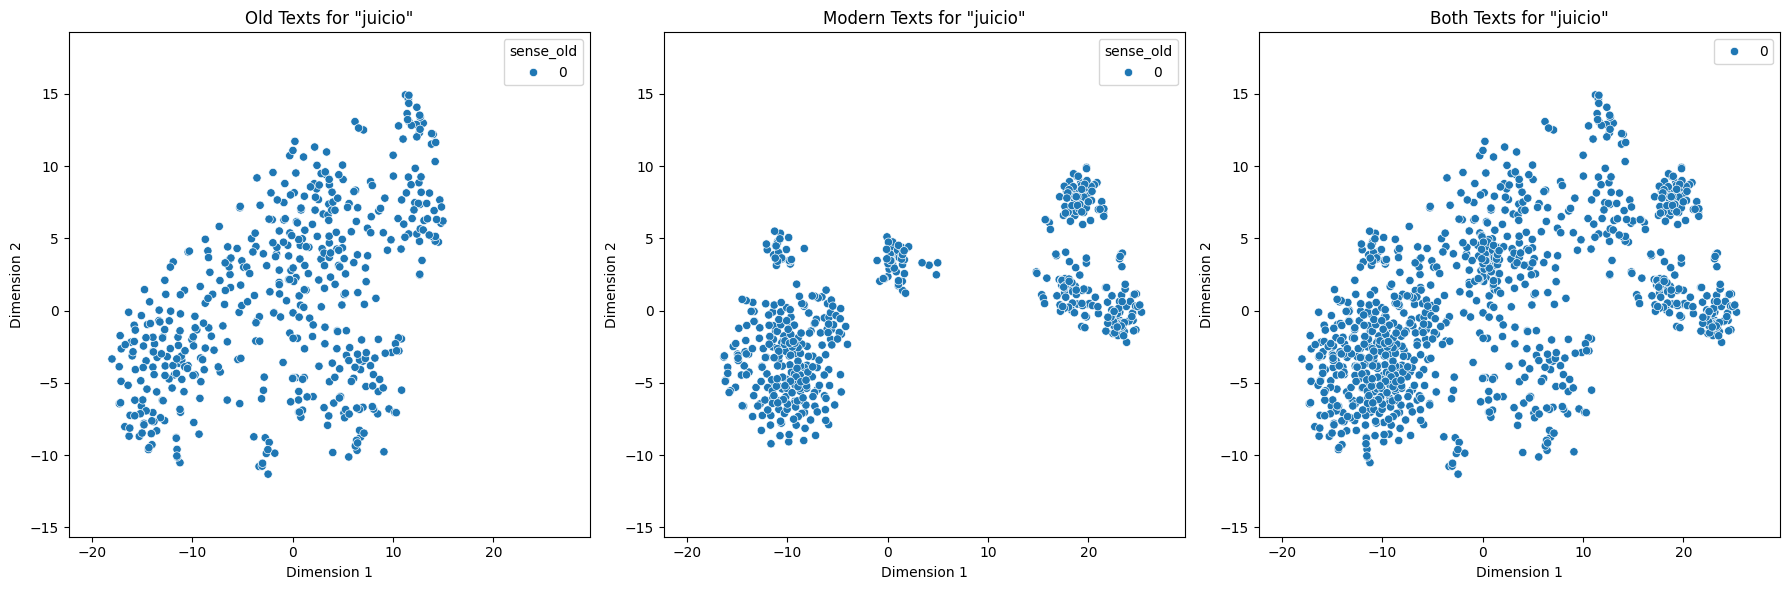

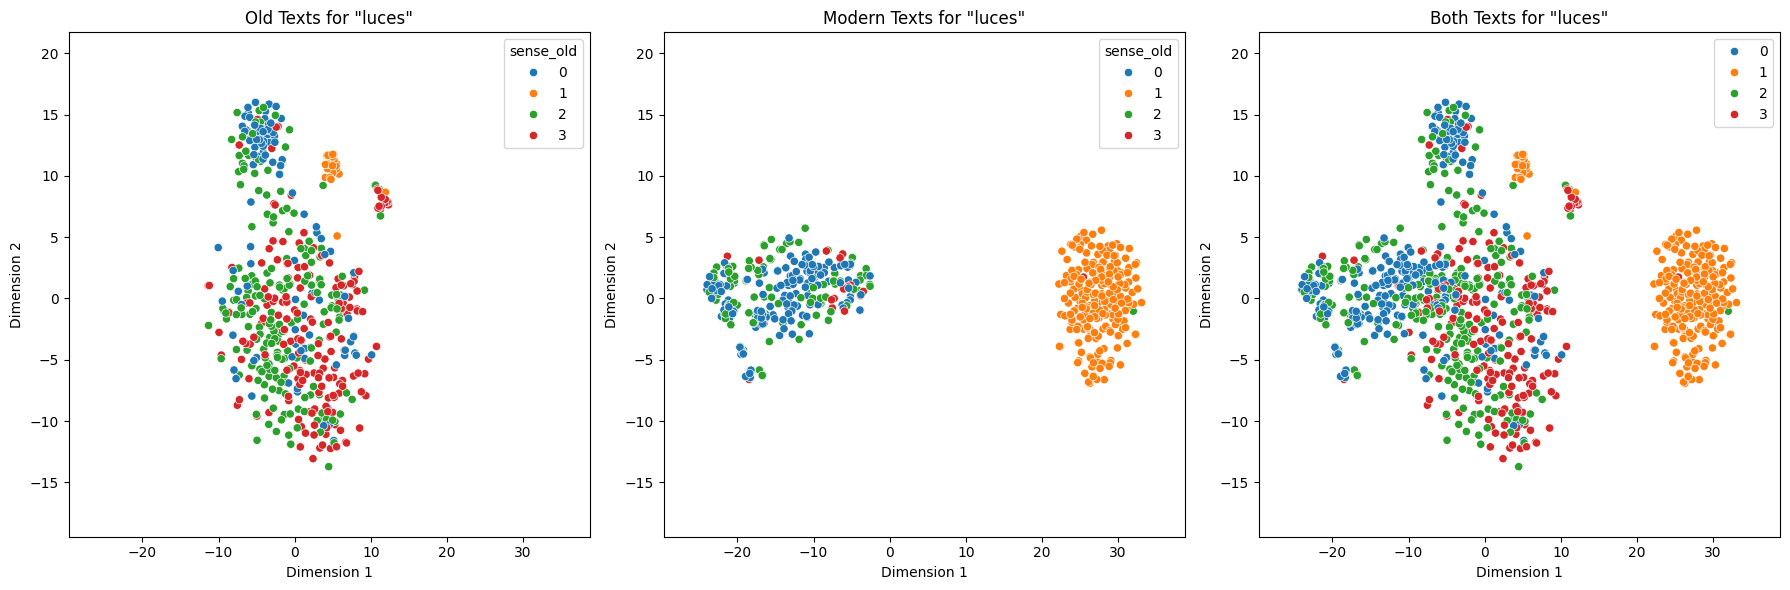

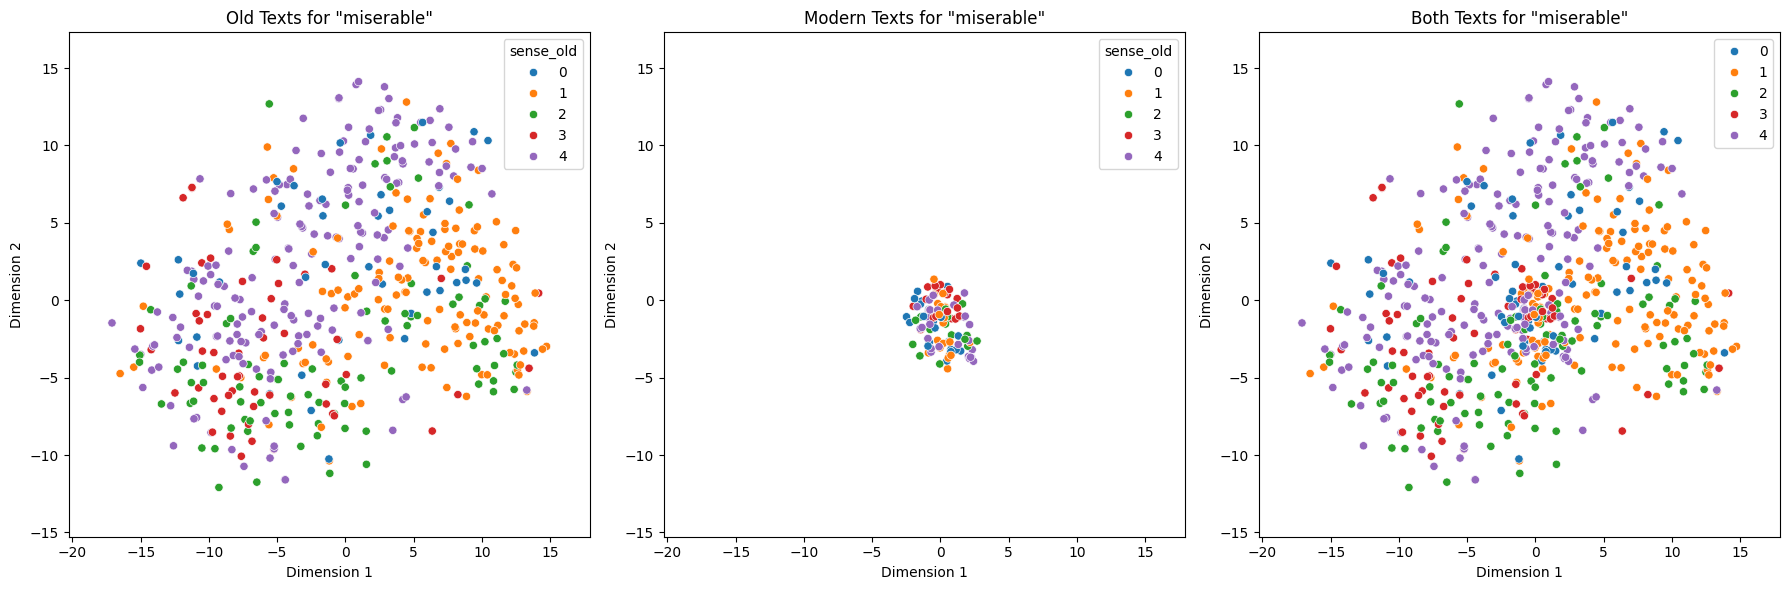

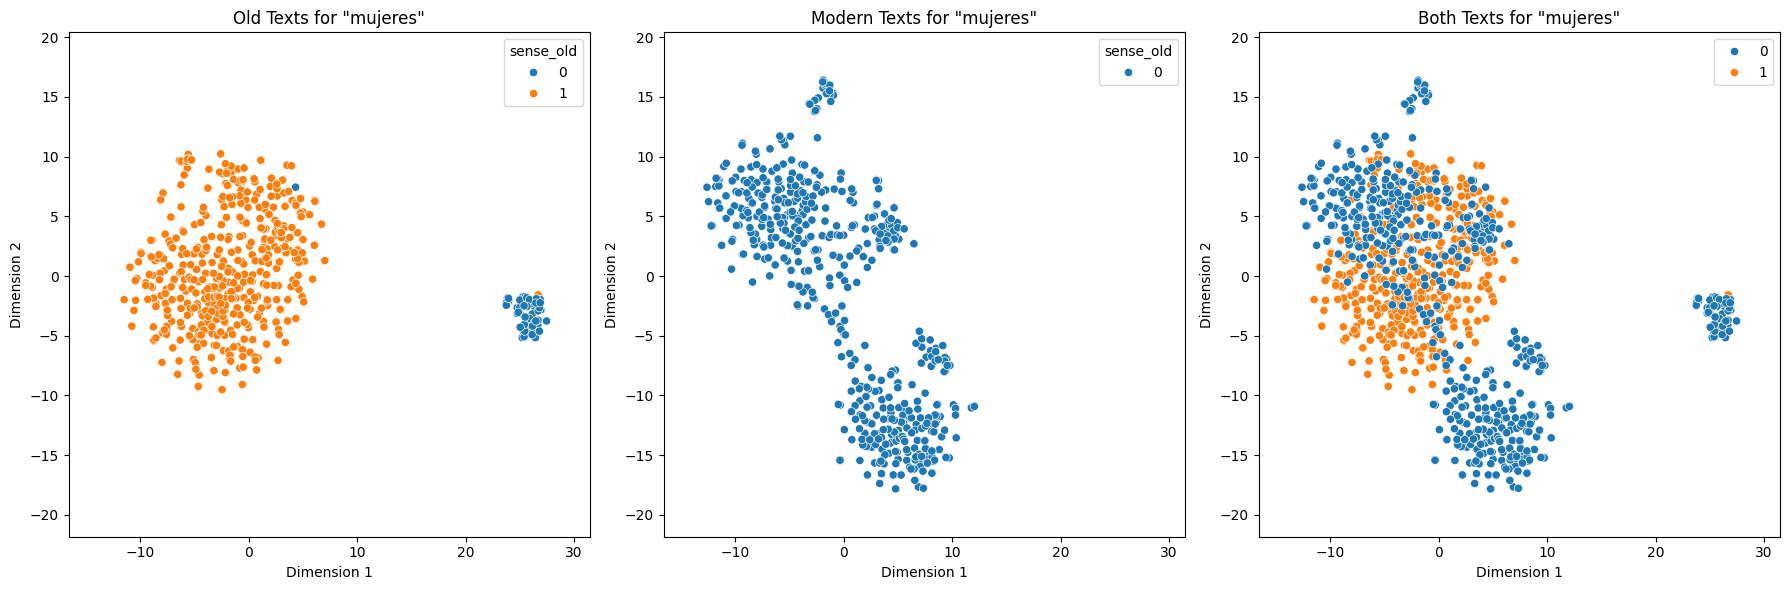

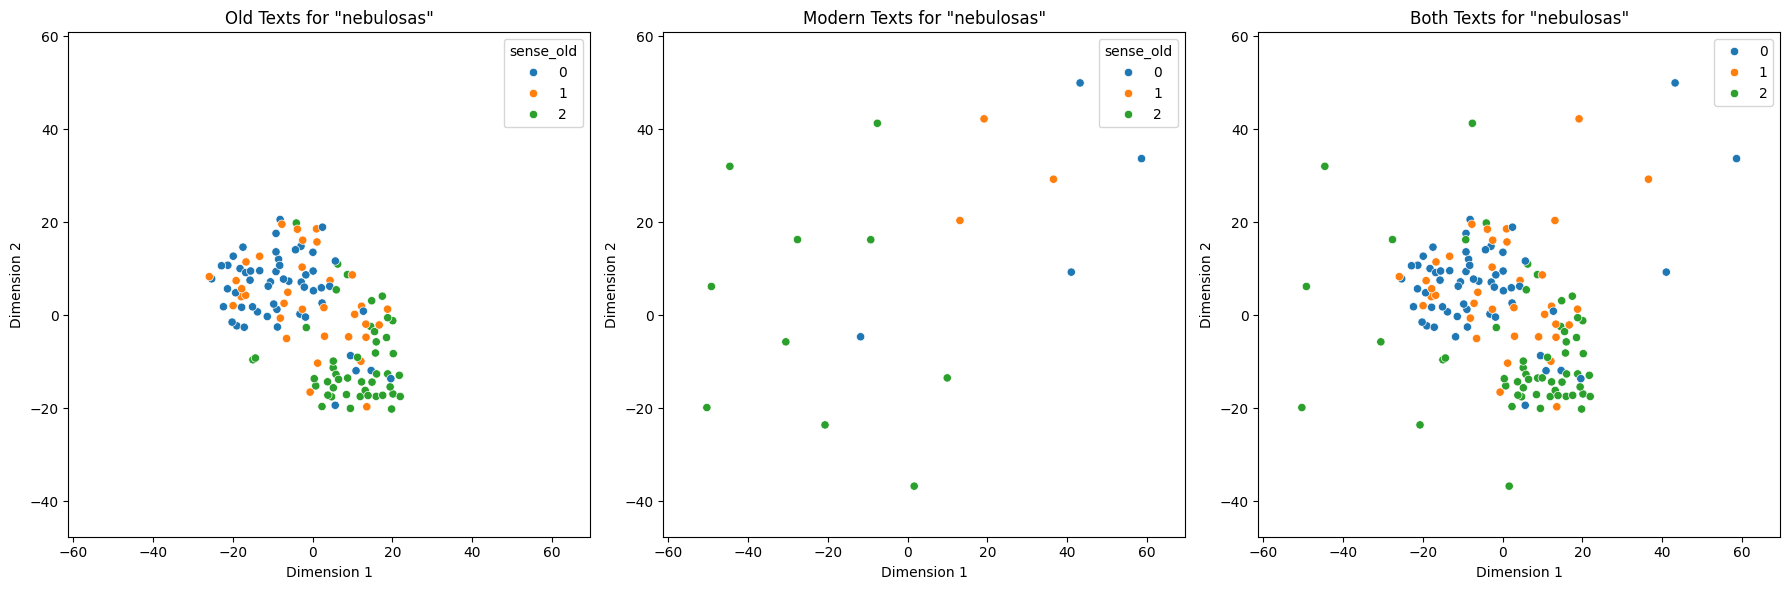

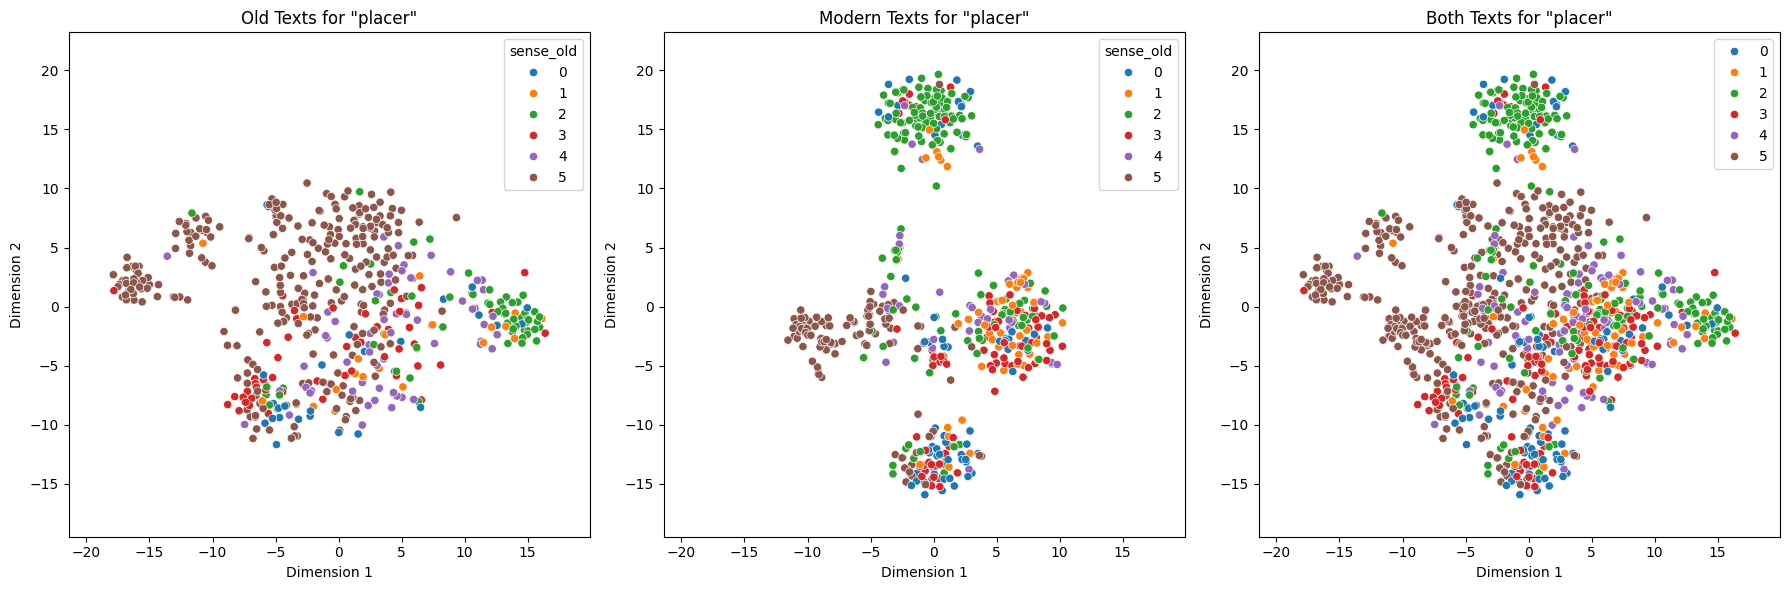

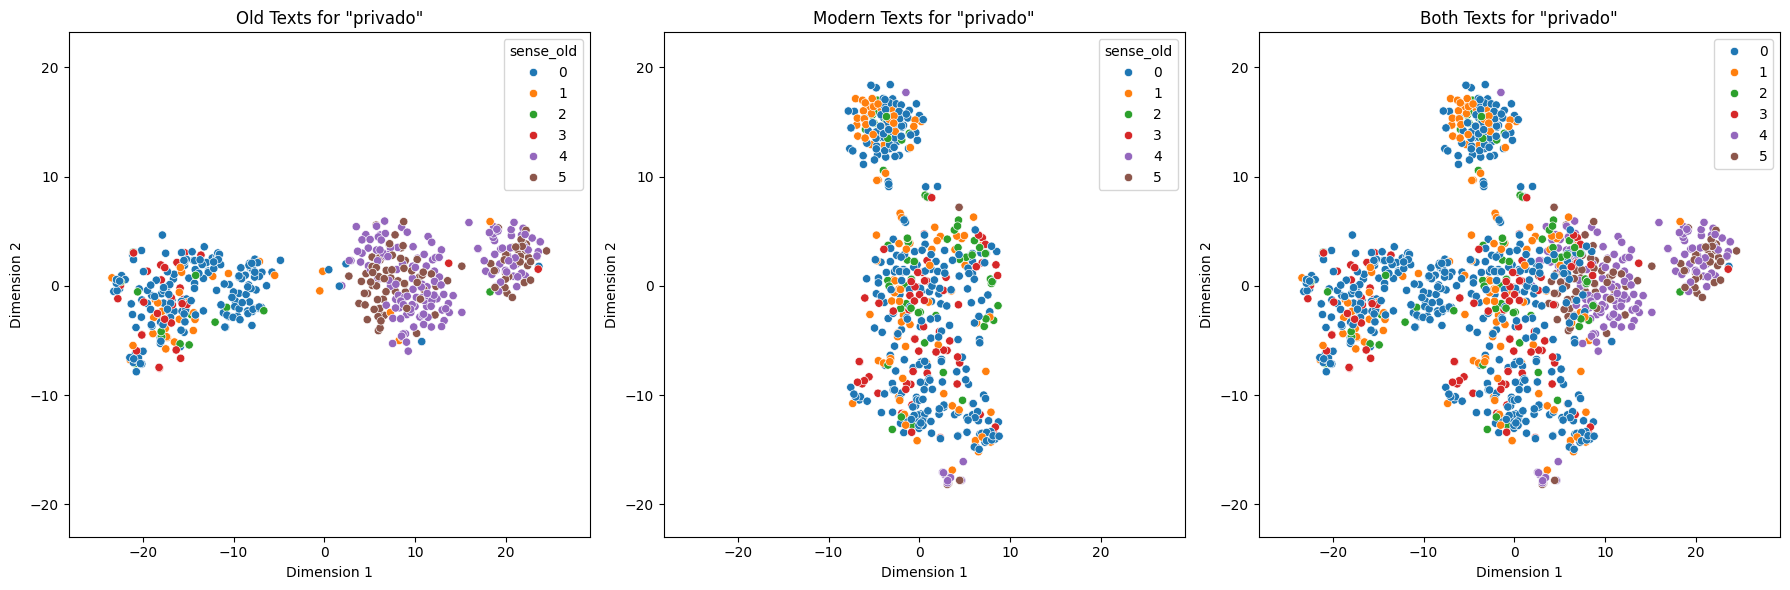

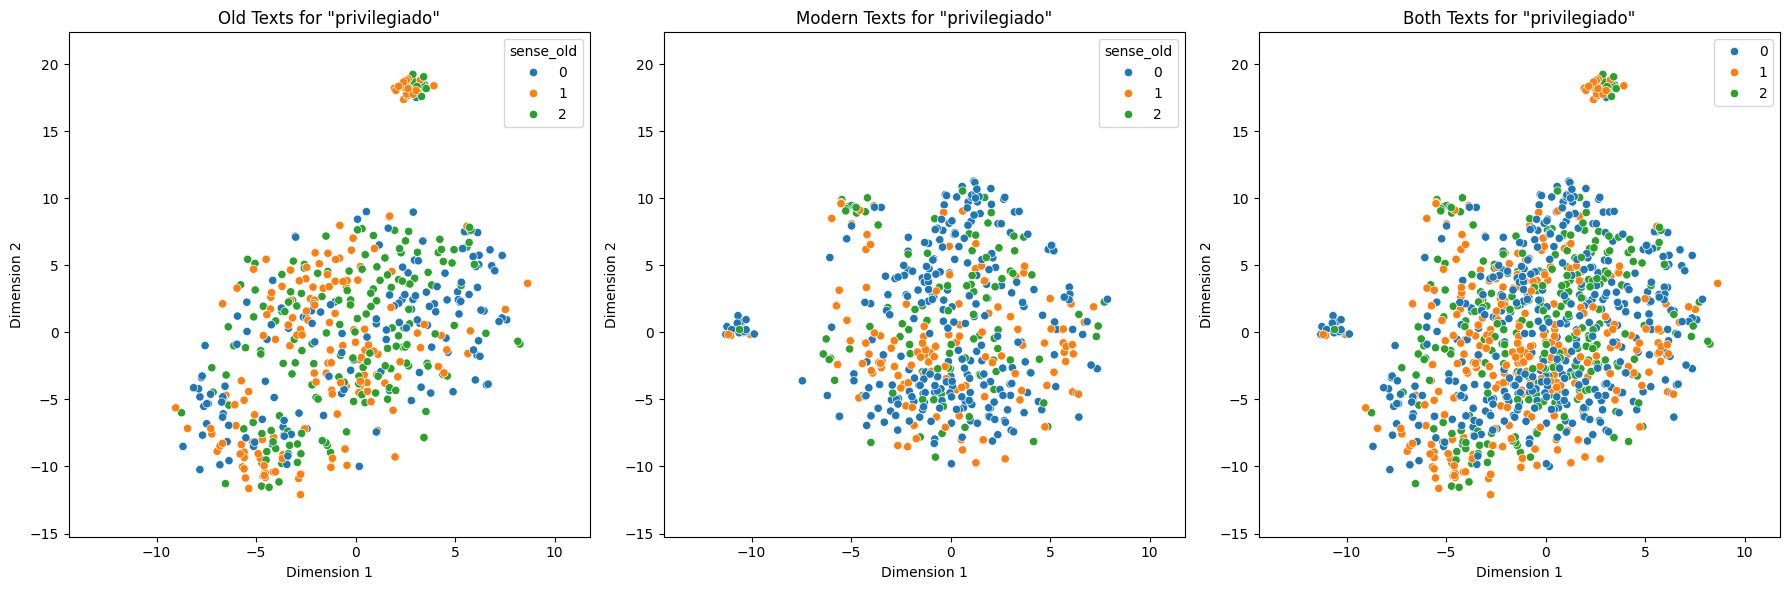

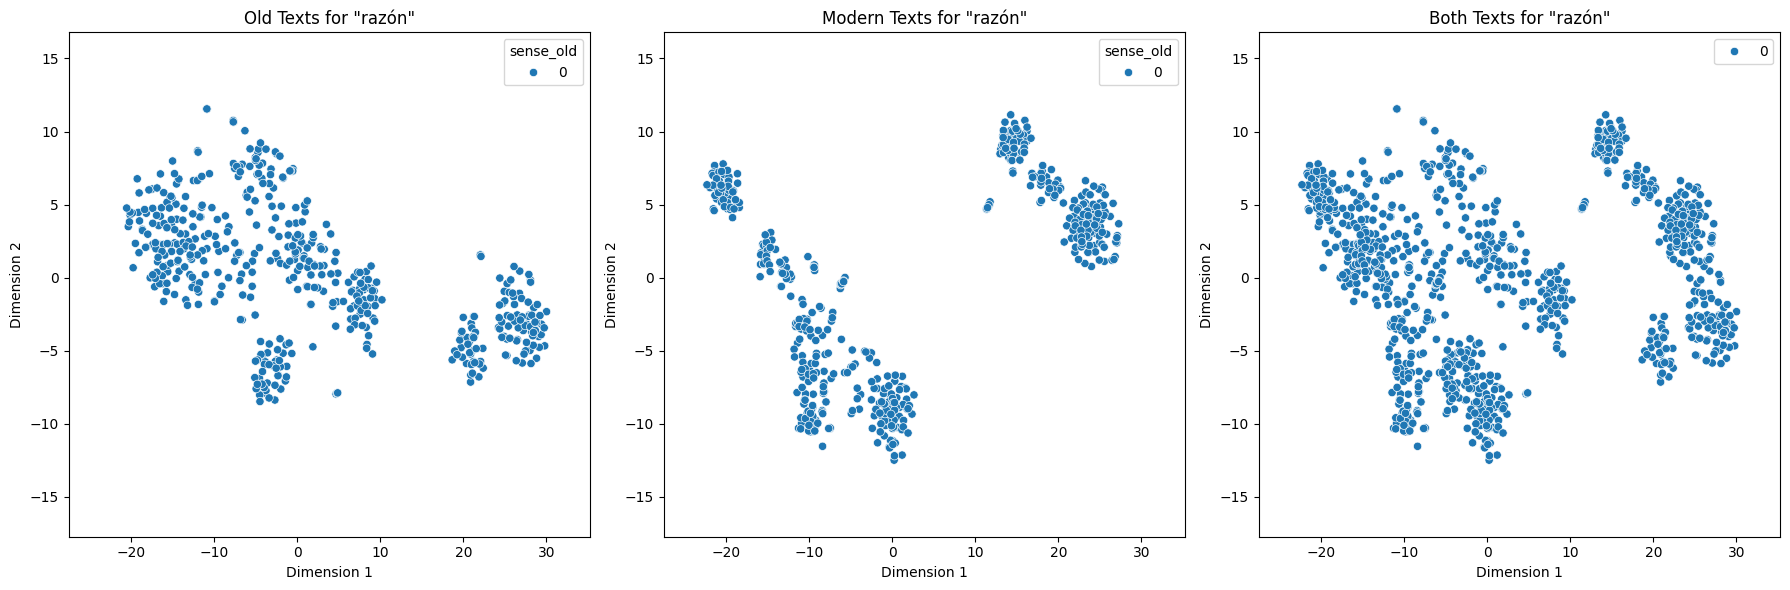

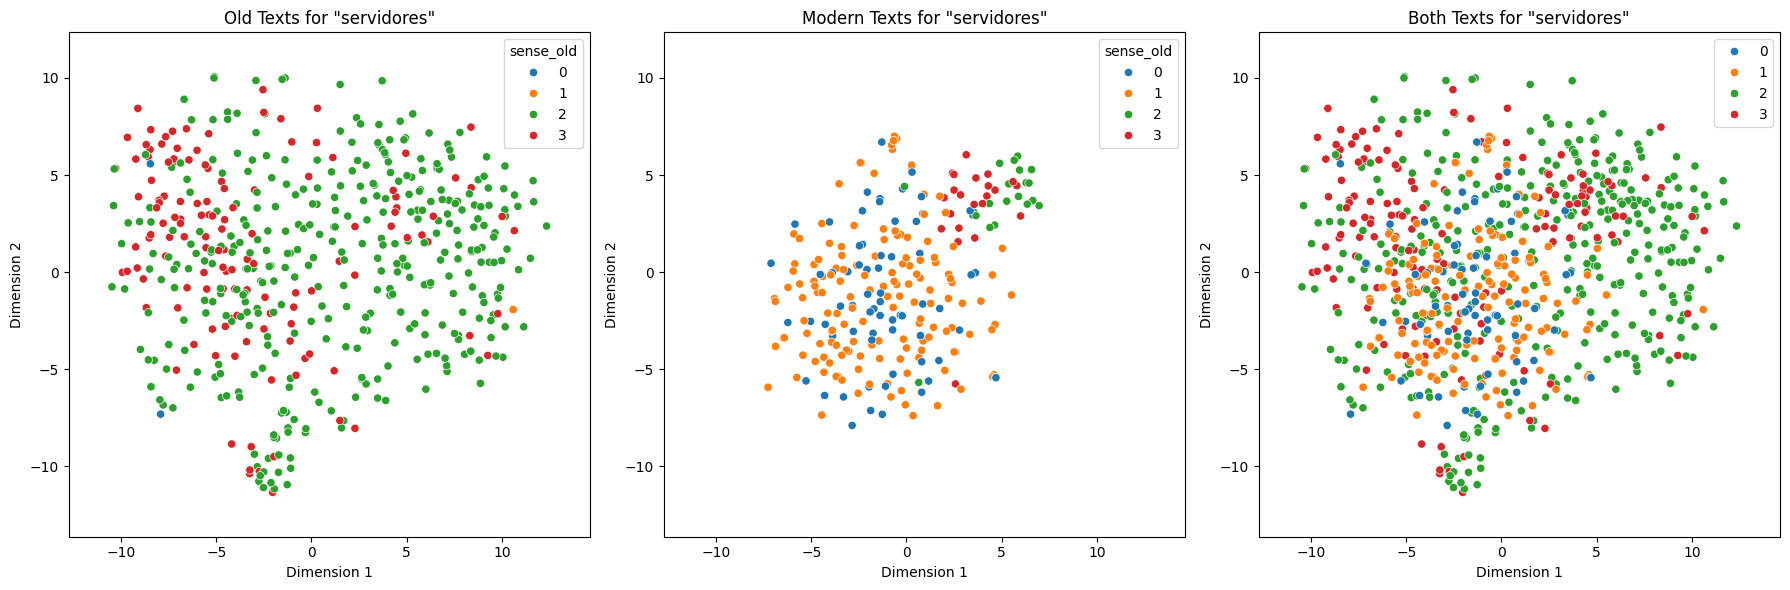

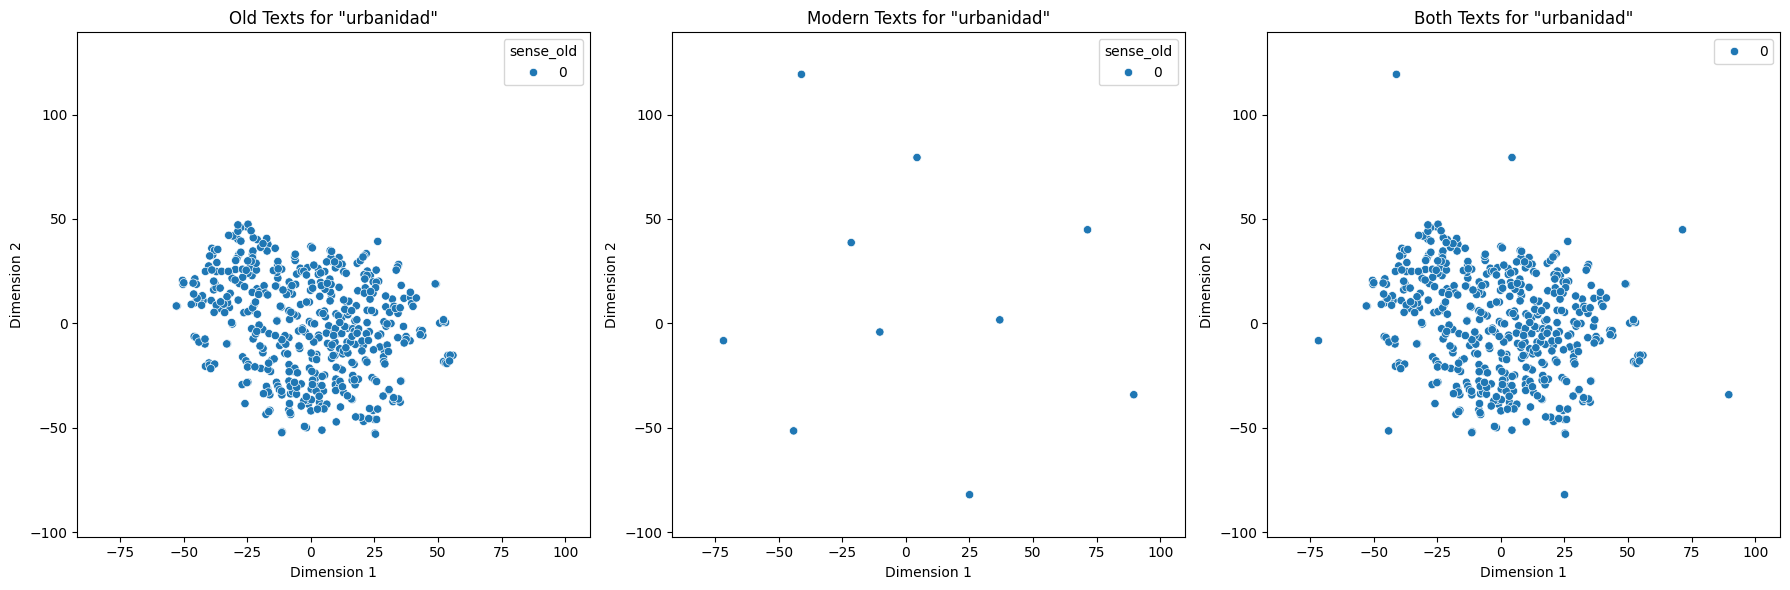

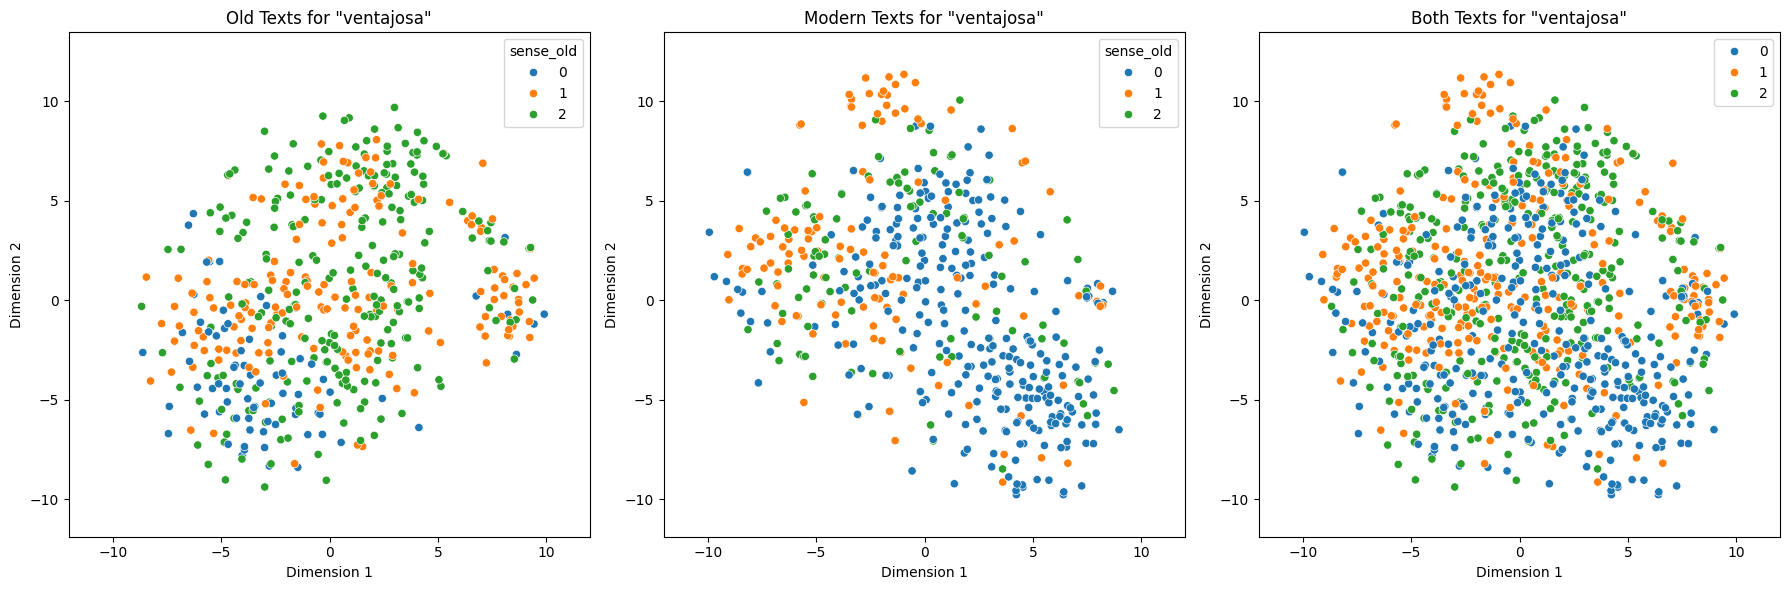

In [39]:
TSNE_PERPLEXITY = 50
TSNE_NUMDIMENSIONS = 2

grouped_df = result_df.groupby('word')

# Define a color palette with more distinct colors
palette = 'tab10'  # You can choose any palette from seaborn or matplotlib

# Iterate over each group and plot its embeddings
for word, group in grouped_df:
    # Split the group by "period"
    old_texts = group[group['period'] == 'old']
    new_texts = group[group['period'] == 'new']
    
    # Convert embeddings to NumPy array and handle variable lengths for both texts
    max_embedding_length_both = max(max(len(embedding) for embedding in old_texts['embedding_old']),
                                     max(len(embedding) for embedding in new_texts['embedding_old']))
    embeddings_array_both_old = np.array([np.pad(embedding, (0, max_embedding_length_both - len(embedding))) for embedding in old_texts['embedding_old']])
    embeddings_array_both_new = np.array([np.pad(embedding, (0, max_embedding_length_both - len(embedding))) for embedding in new_texts['embedding_old']])
    
    # Reduce dimensionality of embeddings using t-SNE for both texts
    tsne_both = TSNE(n_components=TSNE_NUMDIMENSIONS, perplexity=min(TSNE_PERPLEXITY, min(len(old_texts),len(new_texts))-5), random_state=42)
    embeddings_2d_both_old = tsne_both.fit_transform(embeddings_array_both_old)
    embeddings_2d_both_new = tsne_both.fit_transform(embeddings_array_both_new)
    
    # Get the minimum and maximum values for both dimensions
    min_x = min(np.min(embeddings_2d_both_old[:, 0]), np.min(embeddings_2d_both_new[:, 0]))
    max_x = max(np.max(embeddings_2d_both_old[:, 0]), np.max(embeddings_2d_both_new[:, 0]))
    min_y = min(np.min(embeddings_2d_both_old[:, 1]), np.min(embeddings_2d_both_new[:, 1]))
    max_y = max(np.max(embeddings_2d_both_old[:, 1]), np.max(embeddings_2d_both_new[:, 1]))
    
    # Add some padding to the range
    padding = 0.1 * (max(max_x - min_x, max_y - min_y))
    min_x -= padding
    max_x += padding
    min_y -= padding
    max_y += padding
    
    # Create a figure with three subplots for the current word
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot old texts
    sns.scatterplot(
        x=embeddings_2d_both_old[:,0], 
        y=embeddings_2d_both_old[:,1], 
        hue=old_texts['sense_old'], 
        palette=palette, 
        legend='full',
        ax=axes[0]
    )
    axes[0].set_title(f'Old Texts for "{word}"')
    axes[0].set_xlabel('Dimension 1')
    axes[0].set_ylabel('Dimension 2')
    axes[0].set_xlim(min_x, max_x)
    axes[0].set_ylim(min_y, max_y)
    
    # Plot new texts
    sns.scatterplot(
        x=embeddings_2d_both_new[:,0], 
        y=embeddings_2d_both_new[:,1], 
        hue=new_texts['sense_old'], 
        palette=palette, 
        legend='full',
        ax=axes[1]
    )
    axes[1].set_title(f'Modern Texts for "{word}"')
    axes[1].set_xlabel('Dimension 1')
    axes[1].set_ylabel('Dimension 2')
    axes[1].set_xlim(min_x, max_x)
    axes[1].set_ylim(min_y, max_y)
    
    # Plot both old and new texts
    sns.scatterplot(
        x=np.concatenate([embeddings_2d_both_old[:,0], embeddings_2d_both_new[:,0]]), 
        y=np.concatenate([embeddings_2d_both_old[:,1], embeddings_2d_both_new[:,1]]), 
        hue=np.concatenate([old_texts['sense_old'], new_texts['sense_old']]), 
        palette=palette, 
        legend='full',
        ax=axes[2]
    )
    axes[2].set_title(f'Both Texts for "{word}"')
    axes[2].set_xlabel('Dimension 1')
    axes[2].set_ylabel('Dimension 2')
    axes[2].set_xlim(min_x, max_x)
    axes[2].set_ylim(min_y, max_y)
    
    plt.tight_layout()
    plt.show()

In [40]:
save_df = result_df.drop(columns=["embedding_new", "embedding_old"])
save_df.to_csv(f'./output/ssd/clustered-{f"KM{CLUSTERING_METRIC}" if CLUSTERING_METHOD=="KM" else "AP"}-{PT_MODEL_NAME}.tsv', sep='\t', index=False)